# Exploratory Analysis: Are 'Customer' More Likely to Use Citibike during Working Hours than 'Subscriber'?

Lingyi Zhang (lz1714)

Using Python3 Kernel

In [1]:
from __future__ import print_function, division
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

## Abstract
In this study, we analyzed whether 'Customer' are more likely than 'Subscriber' to use Citibike during working hours (9:00 - 17:00). Using one-tailed Z-test and Chisq test, we found that the percentage of riders used CitiBike during working hours is significantly higher for 'Customer' than for 'Subscriber'.

## 1. Introduction
CitiBike is a privately owned public bicycle sharing system serving New York City and Jersey City, New Jersey. [1] It is the nation's largest bike share program, with 10,000 bikes and 600 stations. There are two user types, 'Customer'(mainly visitors and tourists) and 'Subscriber' (mainly New York locals). [2] 
The question we want to answer in this article is that whether 'Customer' are more likely than 'Subscriber' to use Citibike during working hours (9:00 - 17:00).
To know that can be helpful for CitiBike owner company (NYC Bike Share, LLC) to make their sales and operation strategies. For example, If we want to provide some targeted services or advertisement to the 'Customer'(Mainly visitors and tourists), this analysis can give the best time span of providing.

## 2. Data
[CitiBike tripdata]("https://s3.amazonaws.com/tripdata/index.html") we used in this analysis is the data of January 2016. We converted the "starttime" column into datetime, which can be easily processed in pandas. We then aggregate the trip counts by hours, calculating the respective percentage of trips started during working hours (9:00 - 17:00) and resting hours (18:00 - 8:00) by "Subscriber" and "Customer". 

In [2]:
def getCitiBikeCSV(datestring):
    ''' A function to download the data
    but more complex command lines with variable 
    arguments need to be build as strng and run with os.system
    this code cell does a lot of things: looks for existing files,
    download a file if none is there, unzips it, moves it.
    '''
    print ("Downloading", datestring)
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("file in place, you can continue")

In [3]:
#download
datestring = '201601'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
#read data
#this cell takes around 110 seconds to process, which is not good
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'])
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender'], axis=1, inplace=True)
df.head()

,usertype,date
0,Subscriber,2016-01-01 00:00:41
1,Subscriber,2016-01-01 00:00:45
2,Subscriber,2016-01-01 00:00:48
3,Subscriber,2016-01-01 00:01:06
4,Subscriber,2016-01-01 00:01:12


In [5]:
type(df['date'][0])

pandas._libs.tslib.Timestamp

In [6]:
sumUsertype = df['usertype'].value_counts()
sumUsertype.shape
print('total Subscriber: {}'.format(sumUsertype.Subscriber))
print('total Customer: {}'.format(sumUsertype.Customer))

total Subscriber: 484935
total Customer: 24543


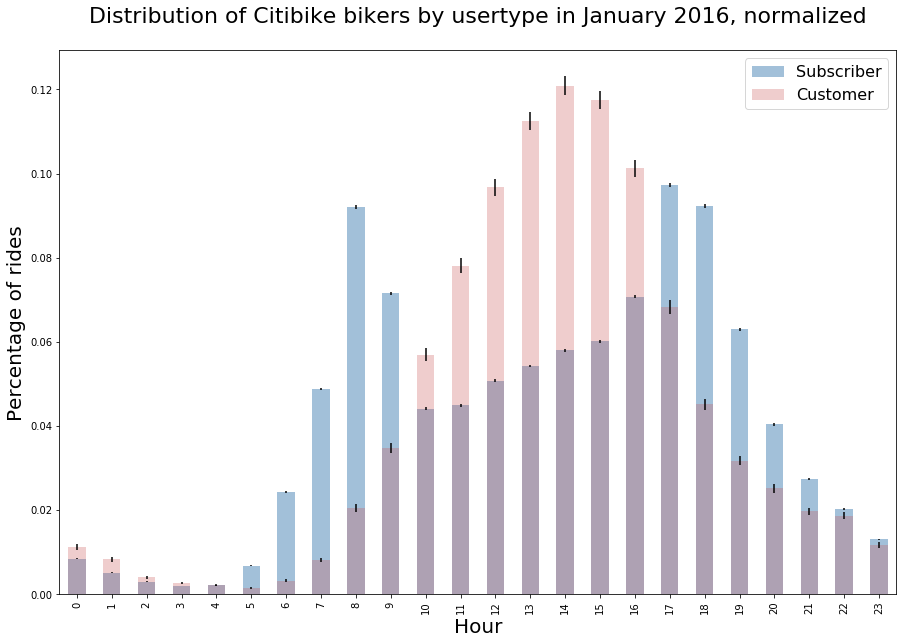

Figure 1. Normalized distribution of CitiBike rider by user-type in different hours. From this figure, we can have a taste of the CitiBike usage pattern between two user-type. "Subscriber" have a lower percentage of rides from 10:00 to 17:00 and from 0:00 to 3:00 compared to "Customer".


In [7]:
#plot the normalized distribution
fig = plt.figure(figsize=(15,10))

countsSubs = df.date[df.usertype == 'Subscriber'].groupby(
    [df['date'].dt.hour]).count()
countsCust = df.date[df.usertype == 'Customer'].groupby(
    [df['date'].dt.hour]).count()

normSubs = countsSubs.sum()
errorSubs = np.sqrt(countsSubs)
ax = ((countsSubs) / normSubs).plot(kind="bar", color='SteelBlue', alpha=0.5,  
                           yerr=[((errorSubs) / normSubs, (errorSubs) / normSubs)], 
                           label='Subscriber')

normCust = countsCust.sum()
errorCust = np.sqrt(countsCust)
ax = ((countsCust) / normCust).plot(kind="bar", alpha=0.3, 
                                yerr=[((errorCust) / normCust, (errorCust) / normCust)], 
                                color='IndianRed', label='Customer')

ax.set_ylabel ("Percentage of rides", fontsize = 20)
ax.set_xlabel ("Hour", fontsize = 20)
plt.title("Distribution of Citibike bikers by usertype in January 2016, normalized", fontsize=22, y=1.04)
plt.legend(['Subscriber','Customer'], fontsize=16)
plt.savefig('Figure1')
plt.show()
print ('Figure 1. Normalized distribution of CitiBike rider by user-type ' +
       'in different hours. From this figure, we can have a taste of ' +
       'the CitiBike usage pattern between two user-type. "Subscriber" ' +
       'have a lower percentage of rides from ' +
       '10:00 to 17:00 and from 0:00 to 3:00 compared to "Customer".')

In [8]:
#Subscriber and Customer using Citibike during working hours
dfwork = df[(df['date'].dt.hour>8)&(df['date'].dt.hour<18)]
Wsub = dfwork['usertype'][dfwork['usertype'] == 'Subscriber'].count()
Wcus = dfwork['usertype'][dfwork['usertype'] == 'Customer'].count()

In [9]:
#Subscriber and Customer using Citibike during resting hours
dfrest = df[(df['date'].dt.hour<9)|(df['date'].dt.hour>17)]
Rsub = dfrest['usertype'][dfrest['usertype'] == 'Subscriber'].count()
Rcus = dfrest['usertype'][dfrest['usertype'] == 'Customer'].count()

In [10]:
#the percentage table
d = {'using CitiBike': ['Subscriber', 'Customer'],
     'working hours': [Wsub/sumUsertype.Subscriber, Wcus/sumUsertype.Customer],
     'resting hours': [Rsub/sumUsertype.Subscriber, Rcus/sumUsertype.Customer]}
contiTable = pd.DataFrame(data=d, 
                    index=['Subscriber', 'Customer'],
                    columns=['working hours',
                             'resting hours'])
contiTable.to_csv('contiTable.csv')
contiTable

,working hours,resting hours
Subscriber,0.551577,0.448423
Customer,0.786497,0.213503


From this table, a higher portion of 'Customer' is observed using CitiBike during working hours than the 'Subscriber'. In the following section, we will test whether this difference is statistically significant.

## 3. Methodology

#### In both tests below, we assign $\alpha = 0.05$

Here we incorporated [Federica's suggestion](eeee) using Chisq test for proportion, because it is appropriate for testing hypotheses about proportions. 

We also did one-tailed Z-test. Because when data sample is large enough (defined as both np and n(1-p) are greater than or equal to 5), the binomial distribution comes to resemble the normal distribution. [3]

In this analysis, we finally didn't use the [t-test suggested by Ian](eeee), because the sample size is large enough. We used Z test instead.

#### 3.1 Chisq test

__Null hypothesis:__ The percentage of trips using Citibike during working hours is the same for 'subscriber' as for 'customer'. (Using Citibike during working hours and the user type are independent.)

$Cust_{\mathrm{WorkingTime}}$: The counts of ‘Customer’ using CitiBike during working hours.                                                
$Subs_{\mathrm{WorkingTime}}$: The counts of ‘Subscriber’ using CitiBike during working hours.                                                
$Cust_{\mathrm{All}}$: The counts of ‘Customer’ using CitiBike during the whole day.                                                
$Subs_{\mathrm{All}}$: The counts of ‘Subscriber’ using CitiBike during the whole day.                                                

#### _$H_0$_ : $\frac{Cust_{\mathrm{WorkingTime}}}{Cust_{\mathrm{All}}} = \frac{Subs_{\mathrm{WorkingTime}}}{Subs_{\mathrm{All}}}$                                                                    
#### _$H_a$_ : $\frac{Cust_{\mathrm{WorkingTime}}}{Cust_{\mathrm{All}}} \neq \frac{Subs_{\mathrm{WorkingTime}}}{Subs_{\mathrm{All}}}$

In [11]:
#the contingency table
d = {'using CitiBike': ['subscriber', 'customer', 'total'],
     'working hours': ['0.552*484935', '0.786*24543', '286782'],
     'resting hours': ['0.448*484935', '0.214*24543', '222696'],
     'summary': ['484935', '24543', '509478']}
contiTable = pd.DataFrame(data=d, 
                    index=['subscriber', 'customer', 'total'],
                    columns=['using CitiBike', 'working hours',
                             'resting hours', 'summary'])
contiTable.to_csv('contiTable2.csv')
contiTable

,using CitiBike,working hours,resting hours,summary
subscriber,subscriber,0.552*484935,0.448*484935,484935
customer,customer,0.786*24543,0.214*24543,24543
total,total,286782,222696,509478


In [12]:
#caculate chisq statistic, the critical value, and P-value
obs = np.array([[0.552 * 484935, 0.448 * 484935],
                [0.786 * 24543, 0.214 * 24543]])
result = stats.chi2_contingency(obs)
critiValue = stats.distributions.chi2.isf(0.05, 1, loc=0, scale=1)

print ('chisq test statistic: {:.3f}'.format(result[0]))
print ('The critical value with alpha = 0.05, DF = 1 is: {:.3f}'.
       format(critiValue))
print ('chisq test P-value: {:.3f}'.format(result[1]))

chisq test statistic: 5198.869
The critical value with alpha = 0.05, DF = 1 is: 3.841
chisq test P-value: 0.000


With alpha = 0.05, we can reject the Null hypothesis. The percentage of trips using Citibike during working hours for 'subscriber' and 'customer' are not the same.

#### 3.2 one-tailed Z test

__Null hypothesis:__  The percentage of trips using CitiBike during working hours is the same or lower for 'Customer' than for 'Subscriber'.  

#### _$H_0$_ : $\frac{Cust_{\mathrm{WorkingTime}}}{Cust_{\mathrm{All}}} <= \frac{Subs_{\mathrm{WorkingTime}}}{Subs_{\mathrm{All}}}$                                                                    
#### _$H_a$_ : $\frac{Cust_{\mathrm{WorkingTime}}}{Cust_{\mathrm{All}}} > \frac{Subs_{\mathrm{WorkingTime}}}{Subs_{\mathrm{All}}}$

In [13]:
counts = np.array([19303, 267479])
nobs = np.array([24543, 484935])
stat, pval = proportions_ztest(counts, nobs, alternative='larger')
critiValue = stats.norm.isf(0.05, loc=0, scale=1)
print ('Z-test statistic: {:.3f}'.format(stat))
print ('The critical value with alpha = 0.05, one-tailed is: {:.3f}'.
       format(critiValue))
print ('Z-test P-value: {:.3f}'.format(pval))

Z-test statistic: 72.386
The critical value with alpha = 0.05, one-tailed is: 1.645
Z-test P-value: 0.000


With alpha = 0.05, we can reject the Null hypothesis. The percentage of trips using CitiBike during working hours is higher for 'Customer' than for 'Subscriber'.

## 4. Conclusions

'Customer' are more likely than 'Subscriber' to use CitiBike during working time. It might be because most of the 'Customer' are tourists, while most of the 'Subscriber' are local labor force. During working hours, a higher proportion of 'Subscriber' are staying in office, while 'Customer' are touring around the city.

Implication: if we want to do advertisement targeting the 'customer', the best time to display the advertisement would be the working hours, because a higher proportion of 'customer' can see the advertisement, while a lower portion of 'subscriber' will be disturbed by useless information for them. As for the type of advertisement, promotion for annual membership would not be a good choice, because tourists are temporally visiting. Instead, promotions about short time discount might be feasible, such as the one-day or three-day pass.

The weakness of this analysis is that we did not consider the seasonality. The conclusion we drew based on data of January might not able to apply to Summer.

## Reference


    [1]CitiBike. Retrive from: https://en.wikipedia.org/wiki/Citi_Bike
    [2]Experience NYC in a whole new way. Retrive from: https://www.citibikenyc.com/how-it-works
    [3]Boslaugh, S. (2012). Statistics in a nutshell: A desktop quick reference (pp. 136): " O'Reilly Media, Inc.".